In [1]:
import scipy
import numpy as np
import random
import uncertainties
from uncertainties import ufloat
import pandas as pd
import matplotlib.pyplot as plt
from constants import *

# Set paths, etc.

In [2]:
MAINPATH = "/Users/research/projects/notes/"
FIG_DIR = MAINPATH + "Figures/"

# Some physical functions

In [3]:
def dur_tot_calc(p, b, ror, rho, e=0., w=0.):
    '''
    Solves for total duration T14 (in days)
    From Winn 2010, Eq 14 with eccentricity consideration from Eq 16
    Approximations used: sin(i) ~ 1, arcsin(x) ~ x
    Args:
        p: period (days)
        b: impact parameter
        rho: stellar density or circular stellar density (g/cc)
        e: eccenticity - if true stellar density is input; default 0
        w: omega, argument of periastron (radians) - if true stellar density is input; default 0
        ror: Rp/Rs
    Returns:
        T14: total transit duration 1->4 (in days)
    '''
    p *= day
    aor = ((p**2 * G * rho) / (3 * np.pi))**(1/3)
    f_ew = ((1-e**2)**(1./2)/(1+e*np.sin(w)))
    dur_tot = p/np.pi * aor**(-1) * ((1+ror)**2 - b**2)**(1/2) * f_ew
    return dur_tot/day

In [4]:
def rho_calc(p, b, ror, T14):
    """
    Solves for implied circuar stellar density
    From Seager & Mallen-Ornelas 2013, Eq 9
    
    Args:
        p: period [days]
        b: impact parameter
        T14: duration [days]
        ror: Rp/Rs
    Returns:
        rho: circular stellar density (g/cc)
    """
    sin2tpop = np.sin(T14*pi/p)**2
    
    kep = 365.25**2/215**3 / p**2
    num = (1+ror)**2 - b**2*(1 - sin2tpop)
    
    return kep*(num/sin2tpop)**(3./2)*rhosun

# Select baseline system parameters

In [7]:
per_inj = 15.
t0_inj = 0.

ror_inj = 0.03
b_inj = 0.5

e_inj = 0.2
w_inj = pi/2.

rho_true = rhosun
rho_true_err = rhosun*0.1

T14_inj = dur_tot_calc(per_inj, b_inj, ror_inj, rho_true, e_inj, w_inj)

params = {'period': per_inj,
         't0': t0_inj,
         'dur': T14_inj,
         'ror': ror_inj,
         'b': b_inj,
         'e': e_inj,
         'omega': w_inj,
         'rho_star': rho_true}

params

{'period': 15.0,
 't0': 0.0,
 'dur': 0.13715577872799928,
 'ror': 0.03,
 'b': 0.5,
 'e': 0.2,
 'omega': 1.570796326794895,
 'rho_star': 1.409779824307527}

# Sample from uniform distributions and calculate likelihood assuming 10% uncertainty on $T_{14}$ and $r_p/R_s$

In [8]:
N = int(1e7)

# draw rho, ror, b
rhosmo_uni = np.random.uniform(rhosun/10, rhosun*10, N)
ror_uni = np.exp(np.random.uniform(np.log(0.001), np.log(0.2), N))
b_uni = np.array([np.random.uniform(0, 1+ror, 1)[0] for ror in ror_uni])

# period is fixed --> get derived total duration (T14)
T14_uni = dur_tot_calc(per_inj, b_uni, ror_uni, rhosmo_uni)

# set assumed 10% errors or
sig_T14 = T14_inj * 0.1
sig_ror = ror_inj * 0.1

# calculate chi-squared for T14 and ror
chi2_T14 = ((T14_uni - T14_inj) / sig_T14)**2
chi2_ror = ((ror_uni - ror_inj) / sig_ror)**2

# calculate log-likelihood
logL = -0.5*chi2_T14 - 0.5*chi2_ror

# weight posterior samples by log-likelihood
w = np.exp(logL)
w /= np.sum(w)

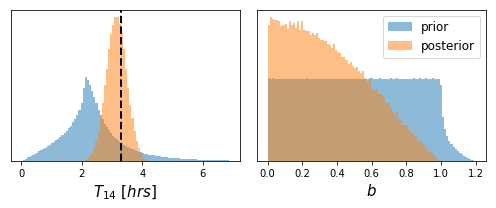

In [9]:
# plot prior distribution vs. posterior distribution
fig, ax = plt.subplots(1,2, figsize=(7,3))

bins = np.linspace(0,np.percentile(T14_uni,99),99)*24

ax[0].hist(T14_uni*24, bins=bins, density=True, label='prior', alpha=0.5)
ax[0].hist(T14_uni*24, weights=w, bins=bins, density=True, label='posterior', alpha=0.5)
ax[0].axvline(T14_inj*24, ls="--", lw=2, color="k")
#ax[0].legend(fontsize=12)
ax[0].set_yticks([])
ax[0].set_xlabel('$T_{14}\ [hrs]$', fontsize=15)

ax[1].hist(b_uni, bins=99, density=True, label='prior', alpha=0.5)
ax[1].hist(b_uni, weights=w, bins=99, density=True, label='posterior', alpha=0.5, color='C1')
ax[1].legend(fontsize=12)
ax[1].set_yticks([])
ax[1].set_xlabel('$b$', fontsize=15)

plt.tight_layout()
plt.savefig(FIG_DIR + 'rhostar_basis_impact_bias.pdf', bbox_inches='tight')
plt.show()

# Can we do better sampling directly in $\log T_{14}$?

In [10]:
N = int(1e7)

# now draw from T14, ror, b
T14_uni = np.exp(np.random.uniform(np.log(0.01), np.log(0.3), N))
#ror_uni = np.random.uniform(0.001, 0.2, N)
ror_uni = np.exp(np.random.uniform(np.log(0.001), np.log(0.2), N))
b_uni = np.array([np.random.uniform(0, 1+ror, 1)[0] for ror in ror_uni])

# set assumed 10% errors or
sig_T14 = T14_inj * 0.1
sig_ror = ror_inj * 0.1

# calculate chi-squared for T14 and ror
chi2_T14 = ((T14_uni - T14_inj) / sig_T14)**2
chi2_ror = ((ror_uni - ror_inj) / sig_ror)**2

# calculate log-likelihood
logL = -0.5*chi2_T14 - 0.5*chi2_ror

# weight posterior samples by log-likelihood
w = np.exp(logL)
w /= np.sum(w)

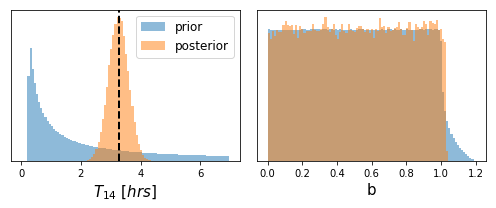

In [11]:
# plot prior distribution vs. posterior distribution
fig, ax = plt.subplots(1,2, figsize=(7,3))

bins = np.linspace(0,np.percentile(T14_uni,99),99)*24

ax[0].hist(T14_uni*24, bins=bins, density=True, label='prior', alpha=0.5)
ax[0].hist(T14_uni*24, weights=w, bins=bins, density=True, label='posterior', alpha=0.5)
ax[0].axvline(T14_inj*24, ls="--", lw=2, color="k")
ax[0].legend(fontsize=12)
ax[0].set_yticks([])
ax[0].set_xlabel('$T_{14}\ [hrs]$', fontsize=15)

ax[1].hist(b_uni, bins=99, density=True, label='prior', alpha=0.5)
ax[1].hist(b_uni, weights=w, bins=99, density=True, label='posterior', alpha=0.5, color="C1")
#ax[1].legend(fontsize=12)
ax[1].set_yticks([])
ax[1].set_xlabel('b', fontsize=15)

plt.tight_layout()
plt.savefig(FIG_DIR + 'duration_basis_impact_bias.pdf', bbox_inches='tight')
plt.show()

# Let's investigate density-eccentricity biases

### Sampling in $\rho_{\rm SMO}$

In [23]:
N = int(1e7)

# draw rho, ror, b
rhosmo_uni = np.random.uniform(rhosun/10, rhosun*10, N)
ror_uni = np.exp(np.random.uniform(np.log(0.001), np.log(0.2), N))
b_uni = np.array([np.random.uniform(0, 1+ror, 1)[0] for ror in ror_uni])

# period is fixed --> get derived total duration (T14)
T14_uni = dur_tot_calc(per_inj, b_uni, ror_uni, rhosmo_uni)

# set assumed 10% errors or
sig_T14 = T14_inj * 0.1
sig_ror = ror_inj * 0.1

# calculate chi-squared for T14 and ror
chi2_T14 = ((T14_uni - T14_inj) / sig_T14)**2
chi2_ror = ((ror_uni - ror_inj) / sig_ror)**2

# calculate log-likelihood
logL = -0.5*chi2_T14 - 0.5*chi2_ror

# weight posterior samples by log-likelihood
w = np.exp(logL)
w /= np.sum(w)


# calculate rhosmo deterministicially
rhosmo = rho_calc(per_inj, b_uni, ror_uni, T14_uni)

# now draw uniform e, omega
ecc = np.random.uniform(0, 1.0, len(rhosmo))
omega = np.random.uniform(-0.5*pi, 1.5*pi, len(rhosmo))


# calculate photoeccentric effect weight
g = (1 + ecc*np.sin(omega)) / np.sqrt(1 - ecc**2)
rho = rhosmo / g**3
log_weightPE = -0.5 * ((rho - rho_true) / rho_true_err) ** 2
weightPE = np.exp(log_weightPE - np.max(log_weightPE))
weightPE /= np.sum(weightPE)

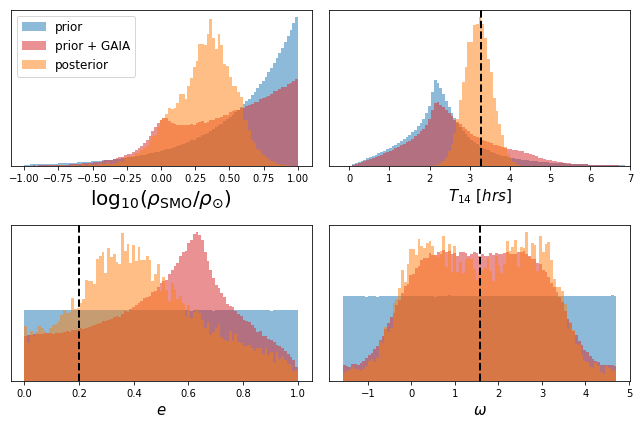

In [24]:
fig, ax = plt.subplots(2,2, figsize=(9,6))

ax[0,0].hist(np.log10(rhosmo/rhosun), weights=None, bins=99, density=True, label='prior', alpha=0.5)
ax[0,0].hist(np.log10(rhosmo/rhosun), weights=weightPE, bins=99, density=True, label='prior + GAIA', alpha=0.5, color='C3')
ax[0,0].hist(np.log10(rhosmo/rhosun), weights=weightPE*w, bins=99, density=True, label='posterior', alpha=0.5, color='C1')
ax[0,0].legend(fontsize=12)
ax[0,0].set_yticks([])
ax[0,0].set_xlabel(r'$\log_{10}(\rho_{\rm SMO}/\rho_{\odot})$', fontsize=20)

bins = np.linspace(0,np.percentile(T14_uni,99),99)*24

ax[0,1].hist(T14_uni*24, weights=None, bins=bins, density=True, label='prior', alpha=0.5)
ax[0,1].hist(T14_uni*24, weights=weightPE, bins=bins, density=True, label='prior + GAIA', alpha=0.5, color='C3')
ax[0,1].hist(T14_uni*24, weights=w*weightPE, bins=bins, density=True, label='posterior', alpha=0.5, color='C1')
ax[0,1].axvline(T14_inj*24, ls="--", lw=2, color="k")
ax[0,1].set_yticks([])
ax[0,1].set_xlim(-0.5,7)
ax[0,1].set_xlabel('$T_{14}\ [hrs]$', fontsize=15)

ax[1,0].hist(ecc, weights=None, bins=99, density=True, label='prior', alpha=0.5, color='C0')
ax[1,0].hist(ecc, weights=weightPE, bins=99, density=True, label='prior + GAIA', alpha=0.5, color='C3')
ax[1,0].hist(ecc, weights=w*weightPE, bins=99, density=True, label='posterior', alpha=0.5, color='C1')
ax[1,0].axvline(e_inj, ls="--", lw=2, color="k")
ax[1,0].set_yticks([])
ax[1,0].set_xlabel(r'$e$', fontsize=15)

ax[1,1].hist(omega, weights=None, bins=99, density=True, label='prior', alpha=0.5, color='C0')
ax[1,1].hist(omega, weights=weightPE, bins=99, density=True, label='prior + GAIA', alpha=0.5, color='C3')
ax[1,1].hist(omega, weights=w*weightPE, bins=99, density=True, label='posterior', alpha=0.5, color='C1')
ax[1,1].axvline(w_inj, ls="--", lw=2, color="k")
ax[1,1].set_yticks([])
ax[1,1].set_xlabel(r'$\omega$', fontsize=15)


plt.tight_layout()
plt.savefig(FIG_DIR + "rhostar_basis_eccentricity_bias.pdf", bbox_inches="tight")
plt.show()

### Sampling in $T_{14}$

In [14]:
N = int(1e7)

# now draw from T14, ror, b
T14_uni = np.exp(np.random.uniform(np.log(0.001), np.log(1.0), N))
ror_uni = np.exp(np.random.uniform(np.log(0.001), np.log(0.2), N))
b_uni = np.array([np.random.uniform(0, 1+ror, 1)[0] for ror in ror_uni])

# set assumed 10% errors or
sig_T14 = T14_inj * 0.1
sig_ror = ror_inj * 0.1

# calculate chi-squared for T14 and ror
chi2_T14 = ((T14_uni - T14_inj) / sig_T14)**2
chi2_ror = ((ror_uni - ror_inj) / sig_ror)**2

# calculate log-likelihood
logL = -0.5*chi2_T14 - 0.5*chi2_ror

# total posterior weight
w = np.exp(logL)
w /= np.sum(w)


# calculate rho_circ deterministicially
rhosmo = rho_calc(per_inj, b_uni, ror_uni, T14_uni)

# now draw uniform e, omega
ecc = np.random.uniform(0, 1.0, len(rhosmo))
omega = np.random.uniform(-0.5*pi, 1.5*pi, len(rhosmo))


# calculate photoeccentric effect weight
g = (1 + ecc*np.sin(omega)) / np.sqrt(1 - ecc**2)
rho = rhosmo / g**3
log_weightPE = -0.5 * ((rho - rho_true) / rho_true_err) ** 2
weightPE = np.exp(log_weightPE - np.max(log_weightPE))
weightPE /= np.sum(weightPE)

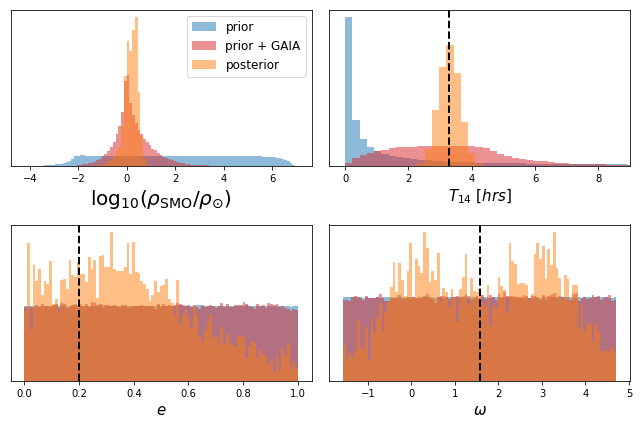

In [22]:
fig, ax = plt.subplots(2,2, figsize=(9,6))

ax[0,0].hist(np.log10(rhosmo/rhosun), weights=None, bins=99, density=True, label='prior', alpha=0.5)
ax[0,0].hist(np.log10(rhosmo/rhosun), weights=weightPE, bins=99, density=True, label='prior + GAIA', alpha=0.5, color='C3')
ax[0,0].hist(np.log10(rhosmo/rhosun), weights=weightPE*w, bins=99, density=True, label='posterior', alpha=0.5, color='C1')
ax[0,0].legend(fontsize=12)
ax[0,0].set_yticks([])
ax[0,0].set_xlabel(r'$\log_{10}(\rho_{\rm SMO}/\rho_{\odot})$', fontsize=20)

bins = np.linspace(0,np.percentile(T14_uni,99),99)*24

ax[0,1].hist(T14_uni*24, weights=None, bins=bins, density=True, label='prior', alpha=0.5)
ax[0,1].hist(T14_uni*24, weights=weightPE, bins=bins, density=True, label='prior + GAIA', alpha=0.5, color='C3')
ax[0,1].hist(T14_uni*24, weights=w*weightPE, bins=bins, density=True, label='posterior', alpha=0.5, color='C1')
ax[0,1].axvline(T14_inj*24, ls="--", lw=2, color="k")
ax[0,1].set_yticks([])
ax[0,1].set_xlim(-0.5,9)
ax[0,1].set_xlabel('$T_{14}\ [hrs]$', fontsize=15)

ax[1,0].hist(ecc, weights=None, bins=99, density=True, label='prior', alpha=0.5, color='C0')
ax[1,0].hist(ecc, weights=weightPE, bins=99, density=True, label='prior + GAIA', alpha=0.5, color='C3')
ax[1,0].hist(ecc, weights=w*weightPE, bins=99, density=True, label='posterior', alpha=0.5, color='C1')
ax[1,0].axvline(e_inj, ls="--", lw=2, color="k")
ax[1,0].set_yticks([])
ax[1,0].set_xlabel(r'$e$', fontsize=15)

ax[1,1].hist(omega, weights=None, bins=99, density=True, label='prior', alpha=0.5, color='C0')
ax[1,1].hist(omega, weights=weightPE, bins=99, density=True, label='prior + GAIA', alpha=0.5, color='C3')
ax[1,1].hist(omega, weights=w*weightPE, bins=99, density=True, label='posterior', alpha=0.5, color='C1')
ax[1,1].axvline(w_inj, ls="--", lw=2, color="k")
ax[1,1].set_yticks([])
ax[1,1].set_xlabel(r'$\omega$', fontsize=15)

plt.tight_layout()
plt.savefig(FIG_DIR + "duration_basis_eccentricity_bias.pdf", bbox_inches="tight")
plt.show()